# Predicting sex of household head in NFHS-3

This notebook works with `household_truncated.csv` (just as is on `data.world`) and tries to build a predictive algorithm for `HV219`: sex of household head.  The code could probably be reviewed and improved.  

Explanation for NFHS-3 and the project is on the [team GitHub project page](https://github.com/Data4Democracy/india-nfhs).

Codebook for variables is available in this folder at `IAHR52FL.txt`.

## Table of contents

1. Import data, remove NAs

2. No Information model

3. Overly simple decision tree model, with five predictors

4. Decision tree with all 'interesting' variables

# 1. Import data, remove NAs

In [58]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sb 

%matplotlib inline
import matplotlib.pyplot as plt

# use low_memory = False so that it reads the dtypes correctly
df = pd.read_csv('household_truncated.csv', na_values='NaN', low_memory=False)

In [59]:
import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability

In [60]:
interesting = ['HV009','HV025', 'HV026', 'HV201', 'HV202', 'HV205', 'HV206', 'HV208', 'HV212', 'HV213',
              'HV214', 'HV215', 'HV216', 'HV217', 'HV219', 'HV220', 'HV221', 'HV226', 'HV227',
              'HV243A', 'HV244', 'HV246', 'HV247', 'HV270', 'SH44', 'SH46', 'SH47N', 'SH58', 
              'SH62A', 'SH62F', 'SHSLI', 'SHSTRUC']

In [61]:
# subset for 'interesting' variables
df2 = df[interesting]

In [62]:
# dict to easily keep track of which survey questions these variables correspond to
q_dict = {'HV009':'Number of listed household members' ,
          'HV025': 'Type of place of residence', 'HV026' : 'Place of residence',
          'HV201' : 'Source of drinking water', 'HV202':'Source of non-drinking water', 
          'HV205':'Type of toilet facility', 'HV206':'Has electricity', 
          'HV208':'Has television', 'HV212':'Has car', 'HV213':'Main floor material',
          'HV214':'Main wall [exterior] material', 'HV215':'Main roof material',
          'HV216':'Rooms used for sleeping', 'HV217':'Relationship structure',
          'HV219': 'Sex of head of household', 'HV220':'Age of head of household',
          'HV221':'Has telephone (non-mobile)', 
          'HV226':'Type of cooking fuel', 'HV227':'Have bednet for sleeping',
          'HV243A': 'Has mobile telephone',
          'HV244':'Owns land usable for agriculture', 'HV246':'Livestock, herds or farm animals',
          'HV247':'Owns a bank account or post office account', 'HV270':'Wealth Index',
          'SH44':'Household head\'s religion', 'SH46':'Type of caste or tribe of the HH head',
          'SH47N':'Has computer', 'SH58':'Owns this or any other house',
          'SH62A':'Has cows/bulls/buffalo', 'SH62F':'Has chickens',
          'SHSLI':'Standard of Living Index', 'SHSTRUC':'Household structure'}

In [63]:
var = 'HV025'
print(var + ': ' + q_dict[var])

HV025: Type of place of residence


In [64]:
stats = {'NAs': df2.isnull().sum(),
        'NAs_percent' : (df2.isnull().sum()/len(df2)*100).round(2),
        'DataType' : df2.dtypes}

stats = DataFrame(stats)
stats.index.name = 'Variables'
stats.columns.name = 'Stats'

In [65]:
stats[stats.NAs_percent > 0]

Stats,DataType,NAs,NAs_percent
Variables,,,
HV201,object,9,0.01
HV202,object,14,0.01
HV205,object,102,0.09
HV206,object,22,0.02
HV212,object,50,0.05
HV213,object,23,0.02
HV214,object,29,0.03
HV215,object,49,0.04
HV216,float64,106,0.10


## Handling NAs

There are not that many NAs, and we have lots of rows, so the easiest thing to do (instead of impuning values) is to simply remove rows with NAs.

In [66]:
df2.shape

(109041, 32)

In [67]:
df2 = df2.dropna(axis=0, how='any')

In [68]:
df2.shape

(101728, 32)

## Quickly check distribution of numerical variables

These are `HV216` (# of sleeping rooms), `HV220` (age of HH head), `HV009` (# of HH members).

0.00     3.0
0.25    35.0
0.50    45.0
0.75    57.0
1.00    98.0
Name: HV220, dtype: float64

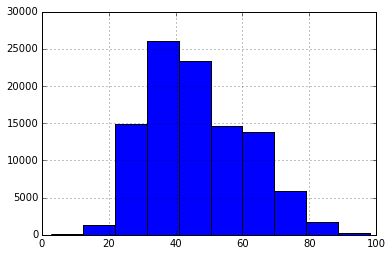

In [69]:
key = 'HV220'
x = df2[key]
x.hist()
x.quantile([0, .25, .5, .75, 1])


# 2. No Information Model

If we want to predict the sex of the head of the household, easiest thing is to just predict 'Male'.  This will be correct `85.6`% of the time.

In [70]:
# value counts for HV219
df2['HV219'].value_counts()

Male      87107
Female    14621
Name: HV219, dtype: int64

In [71]:
len(df2[df2['HV219'] == 'Male'])/len(df2)*100

85.62735923246304

# 3. Overly simple decision tree model, with few predictors

From my earlier EDA, I know that the main variables that relate to HV219 in an interesting way are:

- HV009: number of listed HH members (numerical)

- HV025: rural/urban (categorical)

- HV217: household structure (categorical)

- HV220: age of HH head (numerical)

- HV270: Wealth Index (categorical)

In [72]:
# for simplicity, restrict to these few columns
cols = ['HV009', 'HV025', 'HV217', 'HV220', 'HV270', 'HV219']
df = df2[cols]

In [73]:
# separate features and labels
df_all_features = df.drop(['HV219'], axis=1)
df_all_labels = df['HV219']

In [74]:
df_all_features.head()

Variables,HV009,HV025,HV217,HV220,HV270
0,6,Rural,Three+ related adults,60.0,Poorer
1,5,Rural,Three+ related adults,32.0,Poorer
2,1,Rural,One adult,60.0,Poorer
3,5,Rural,Three+ related adults,69.0,Middle
4,7,Rural,Three+ related adults,65.0,Middle


In [75]:
# get dummy categorical features
df_all_features = pd.get_dummies(df_all_features)
df_all_features.shape

(101728, 15)

In [76]:
df_all_features.columns

Index(['HV009', 'HV220', 'HV025_Rural', 'HV025_Urban', 'HV217_No adults',
       'HV217_One adult', 'HV217_Three+ related adults',
       'HV217_Two adults, opposite sex', 'HV217_Two adults, same sex',
       'HV217_Unrelated adults', 'HV270_Middle', 'HV270_Poorer',
       'HV270_Poorest', 'HV270_Richer', 'HV270_Richest'],
      dtype='object')

In [77]:
from sklearn.model_selection import train_test_split

# split manually into training/testing sets
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(df_all_features, df_all_labels, train_size=0.75, random_state=1)

## Decision tree

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# create the classifier
dtc = DecisionTreeClassifier()

# train the classifier on the training set
%time dtc.fit(training_inputs, training_classes)

# validate the classifier on the testing set using classification accuracy
dtc.score(testing_inputs, testing_classes)

CPU times: user 255 ms, sys: 15.3 ms, total: 270 ms
Wall time: 288 ms


0.87991506763133065

We can repeat the fit many times and plot the model accuracies.

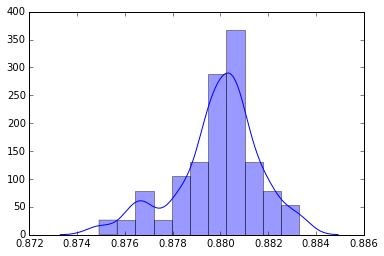

In [79]:
# do it many times and keep track of the model accuracies, then plot them
model_accuracies = []

for repetition in range(50):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(df_all_features, df_all_labels, train_size=0.75)
    
    dtc = DecisionTreeClassifier()
    dtc.fit(training_inputs, training_classes)
    classifier_accuracy = dtc.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
sb.distplot(model_accuracies)

# 4. Decision tree with all 'interesting' variables

In [80]:
df2.shape

(101728, 32)

In [81]:
# separate features and labels
df2_all_features = df2.drop(['HV219'], axis=1)
df2_all_labels = df2['HV219']

In [82]:
# get dummy categorical features
df2_all_features = pd.get_dummies(df2_all_features)
df2_all_features.shape

(101728, 163)

In [83]:
from sklearn.model_selection import train_test_split

# split manually into training/testing sets
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(df2_all_features, df2_all_labels, train_size=0.75, random_state=1)

Now we're ready to build the model.

In [84]:
# create the classifier
dtc = DecisionTreeClassifier()

# train the classifier on the training set
%time dtc.fit(training_inputs, training_classes)

# validate the classifier on the testing set using classification accuracy
dtc.score(testing_inputs, testing_classes)

CPU times: user 7.04 s, sys: 242 ms, total: 7.28 s
Wall time: 7.97 s


0.83072507077697388

Worse than the No Information model.  Overwhelmed by all the dummy versions of categorical variables?

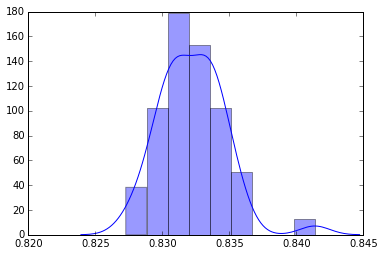

In [85]:
# do it many times and keep track of the model accuracies, then plot them
model_accuracies = []

for repetition in range(50):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(df2_all_features, df2_all_labels, train_size=0.75)
    
    dtc = DecisionTreeClassifier()
    dtc.fit(training_inputs, training_classes)
    classifier_accuracy = dtc.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
sb.distplot(model_accuracies)

# 5. Imputing values and trying a random forest 

We're first going to load in the data again and check that all of the values in the columns we'll use fall in the range prescribed by the data description file, IAHR52FL.txt.

In [86]:
df = pd.read_csv('household_truncated.csv', na_values='NaN', low_memory=False)
df = df[interesting]
df_all_features = df.drop(['HV219'], axis=1)
df_all_labels = df['HV219']

In [87]:
print(df_all_features.describe())
for cat in df_all_features.select_dtypes(['O']):
    print("{0}: {1} unique categories".format(cat, len(df_all_features[cat].unique())))

               HV009          HV216          HV220
count  109041.000000  108935.000000  109028.000000
mean        4.898717       1.750374      46.322394
std         2.518529       0.991199      14.366849
min         1.000000       1.000000       3.000000
25%         3.000000       1.000000      35.000000
50%         5.000000       2.000000      45.000000
75%         6.000000       2.000000      57.000000
max        35.000000      20.000000      98.000000
HV025: 2 unique categories
HV026: 4 unique categories
HV201: 15 unique categories
HV202: 14 unique categories
HV205: 13 unique categories
HV206: 3 unique categories
HV208: 2 unique categories
HV212: 3 unique categories
HV213: 15 unique categories
HV214: 18 unique categories
HV215: 21 unique categories
HV217: 6 unique categories
HV221: 3 unique categories
HV226: 12 unique categories
HV227: 3 unique categories
HV243A: 3 unique categories
HV244: 3 unique categories
HV246: 3 unique categories
HV247: 4 unique categories
HV270: 5 unique cate

For HV220 (age of household head), '98' is the response used for 'don't know'. 0-97 are the actual ages.

For HV206, HV212, HV221, HV227, HV243A, HV244, HV246, HV247, SH47N, SH58, SH62A, SH62F, and SHSLI, '9' is used to signify 'missing', so we'll need to other take out these rows or impute the missing values.

HV226, SH44, and SH46 uses '99' for missing.

This suggests (**TODO**) we need to either remove the rows with the 'missing' data or we need to impute the missing values correctly. For now, we've done basic imputation:

To be able to use all of our data, we'll try imputing the NA values rather than dropping rows with NA. For the categorical variables, we can impute those by filling NAs with the most frequently occurring category. For the numeric variables, we'll fill with the median of the column. To do both in one shot, we'll use some code taken from [StackOverflow](https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn):

In [88]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

Next, we'll binarize our labels (from Male/Female to 0/1), impute missing column data, one-hot encode our existing features, and save the feature names for later use. 

In [89]:
from sklearn import preprocessing

df_all_labels = preprocessing.LabelBinarizer().fit_transform(df['HV219'])
df_all_features = DataFrameImputer().fit_transform(df_all_features)
df_all_features = pd.get_dummies(df_all_features)
feature_names = df_all_features.columns

We'll run a random forest classifier on our data, finding the optimal number of trees with grid search.

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

# split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(df_all_features, 
        df_all_labels, train_size=0.8, random_state=1)

# sklearn needs column vectors for y
y_train, y_test = y_train.ravel(), y_test.ravel()

trees_to_test = [10, 20, 50, 100]

clf = RandomForestClassifier(random_state=0)
grid_clf = GridSearchCV(clf, {'n_estimators': [10, 20, 50, 100]}, cv=10)
grid_clf.fit(X_train, y_train)
model = grid_clf.best_estimator_
print("Best params from grid search are %s" % grid_clf.best_params_)
print("Best score from grid search on left-out data was %s" % grid_clf.best_score_)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Random forest accuracy with best params: {0} \nPrecision: {1} \nRecall: {2} \nF1: {3}"
        .format(metrics.accuracy_score(y_test, y_pred), metrics.precision_score(y_test, y_pred),
        metrics.recall_score(y_test, y_pred), metrics.f1_score(y_test, y_pred)))

zipped = zip(model.feature_importances_, feature_names)
zipped = sorted(zipped, key = lambda t: t[0], reverse=True)

print("\nMOST IMPORTANT FEATURES:")
for (weight, word) in zipped[:len(interesting) // 5]:
    print("{}\t{:.6f}".format(word, weight))

Best params from grid search are {'n_estimators': 100}
Best score from grid search on left-out data was 0.8961046404988995
Random forest accuracy with best params: 0.8982530148103994 
Precision: 0.907610847189232 
Recall: 0.981169421708661 
F1: 0.9429577645818873

MOST IMPORTANT FEATURES:
HV220	0.090928
HV217_One adult	0.080051
HV009	0.073486
HV217_Two adults, same sex	0.037470
HV217_Two adults, opposite sex	0.035099
HV216	0.025500


We certainly see a better accuracy with the random forest in predicting the sex of the head of household. Next, we should try imputing the data for the 'hidden' missing values correctly - for values in the dataframe such as '9' or '99' that are used to indicate missing data rather than actually categories/numbers.